In [486]:
# Import Libraries
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
# from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display
import geopy
from pathlib import Path  
from bs4 import BeautifulSoup
import urllib
import json
import ast
import geopandas as gpd
import snscrape.modules.twitter as sntwitter
import datetime 
from matplotlib import colors
# import matplotlib.cm as cm
from pylab import text
import collections


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amer_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Master functions
*Functions that I would use everywhere*

### Wordcloud generator
*All this function does is initialize the wordcloud data in one simple place so it's cleaner later

In [487]:
def topwords(textDF,top):
    stopwords = set(STOPWORDS)
    extrawords = keyword.split()
    extrawords+=['https','http','www','will',keyword,'college','student','students','know','colleges','university']
    stopwords.update(extrawords)
    newTweets = textDF['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    words = newTweets.tolist()
    # split words into a list of its words
    words = [word.split() for word in words]
    count =collections.Counter([x for sublist in words for x in sublist])
    
    newcount = count.copy()
    for key in count.keys():
        if len(key) < 4:
            del newcount[key]
    # count is a dictionary
    max ={}
    for k,v in newcount.most_common(top):
        max[k] = v
    return(max)



In [488]:
def pullTweets(keyword,noOfTweet,time):
    tweets_list2 = []
    for j,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword + ' ' + time).get_items()):
        tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
        if j == noOfTweet-1:
            return tweets_list2
    return tweets_list2
def percentage(part,whole):
    return 100 * float(part)/float(whole)
def average(arr):
    if len(arr)>0:
        return round((sum(arr) / len(arr)),4)

In [489]:

noOfTweet = 50000
keyword = 'Berkeley'
currentYear = datetime.datetime.now().year
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
file_dir = Path.cwd()

json_folder = 'Colleges'
file_path = os.path.join(file_dir, json_folder, (f'{keyword}.csv'))
# extract the county collumn from the countyDF and convert its values to a list
usefulTweets = 0
users = []
county_needed = []
tweets_list2 = []
total_data = []
collegeDF = pd.DataFrame(columns=['pos','posCount','neg','negCount','neu','neuCount','count','comp','Top Words'])
collegeDF


,pos,posCount,neg,negCount,neu,neuCount,count,comp,Top Words


In [490]:
# First thing is to iterate through each month after working
searchword = ''
for month in range(1,14):
    currentMonth = datetime.datetime.now().month
    # start at the last completed month and count forward
    monthy = currentMonth-1
    monthy +=month-1
    if(monthy>12):
        monthy = monthy-12
        year = currentYear
    else:
        year = currentYear-1
    # I could probably make a way to flip between 30 and 31 days in a month but I'm lazy and it's one day
    if (monthy ==2):
        day = 28
    else:
        day = 30
    timeSearchParams = f'until:{year}-{monthy}-{day} since:{year}-{monthy}-01'
    print(timeSearchParams)
    tweets_list2 = pullTweets(keyword,noOfTweet,timeSearchParams)
    # One of the issues found was that due to the repeated run command, this would have trouble breaking on its own

    # Thus I wrote it into a function that would break and return the needed data at the limi
    tweets_df = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
    posList = []
    negList = []
    neuList = []
    compList = []
    tweetlist = []
    posCount,negCount,neuCount = 0,0,0
    for index,tweet in tweets_df.iterrows():
        # location = tweet.user.location
        username = tweet['Username']
        tweetText = tweet['Text']
        analysis = TextBlob(tweetText)
        score = SentimentIntensityAnalyzer().polarity_scores(tweetText)
        # SCORE RETURNING IS FINE
        neg = score['neg']

        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        # comp variable still works
        # ISSUE IS WITH UP HERE!!!
        # sortTweetCondition = (username not in users) and (tweetText not in tweet_list)
        sortTweetCondition = True
        if (sortTweetCondition == True):
            # append each score to their respective list
            posList.append(pos)
            negList.append(neg)
            neuList.append(neu)
            compList.append(comp)
            usefulTweets+=1
            polarity += analysis.sentiment.polarity
            if neg > pos:
                negative_list.append(tweetText)
                negative += 1
                negCount+=1
            elif pos > neg:
                positive_list.append(tweetText)
                positive += 1
                posCount+=1
            elif pos == neg:
                neutral_list.append(tweetText)
                neutral += 1
                neuCount+=1
            users.append(username)
            tweetlist.append(tweetText)
            if(searchword !='' and searchword in tweetText):print(username + " " + tweetText)
            
        
        # save the cityDict to a json file at directory file_path
        
    pos = average(posList)
    neg = average(negList)
    neu = average(neuList)    
    comp = average(compList)    
    count = posCount+negCount+neuCount
    tweetlist=pd.DataFrame(tweetlist)
    tw_list = pd.DataFrame(tweetlist)
    tw_list["text"] = tw_list[0]

    #Removing RT, Punctuation etc
    remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
    rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
    tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
    tw_list["text"] = tw_list.text.str.lower()
    tw_list.head(tweetlist.shape[0])
    topWords = topwords(tw_list,10)
    
    if(len(posList) > 0):
        collegeDF.loc[month] = [pos,posCount,neg,negCount,neu,neuCount,count,comp,topWords]
    else:
        print(f'{month} returned no tweets')
collegeDF.to_csv(file_path)
# delete the second index of cityDict
# make a new dictionary identical to countyDict but without the second index

collegeDF

until:2021-2-28 since:2021-2-01
until:2021-3-30 since:2021-3-01
until:2021-4-30 since:2021-4-01
until:2021-5-30 since:2021-5-01
until:2021-6-30 since:2021-6-01
until:2021-7-30 since:2021-7-01
until:2021-8-30 since:2021-8-01
until:2021-9-30 since:2021-9-01
until:2021-10-30 since:2021-10-01
until:2021-11-30 since:2021-11-01
until:2021-12-30 since:2021-12-01
until:2022-1-30 since:2022-1-01
until:2022-2-28 since:2022-2-01


,pos,posCount,neg,negCount,neu,neuCount,count,comp,Top Words
1,0.0883,11152,0.0454,5807,0.8663,9663,26622,0.1280,"{'berkeley': 26386, 'california': 1741, 'peopl..."
2,0.0904,11948,0.0437,5594,0.8659,10005,27547,0.1428,"{'berkeley': 27258, 'california': 1769, 'schoo..."
3,0.0910,11059,0.0426,5075,0.8665,9664,25798,0.1455,"{'berkeley': 25516, 'california': 1411, 'park'..."
4,0.0862,10706,0.0450,5412,0.8688,10199,26317,0.1256,"{'berkeley': 26050, 'park': 1786, 'california'..."
5,0.0856,8983,0.0467,4819,0.8677,7798,21600,0.1231,"{'berkeley': 21358, 'california': 1433, 'count..."
6,0.0831,9067,0.0468,4933,0.8701,8576,22576,0.1149,"{'berkeley': 21829, 'california': 1321, 'count..."
7,0.0805,9793,0.0464,5668,0.8731,9925,25386,0.1041,"{'berkeley': 24616, 'california': 1623, 'count..."
8,0.0821,10175,0.0441,5334,0.8737,9937,25446,0.1192,"{'berkeley': 24746, 'california': 1650, 'schoo..."
9,0.0855,10878,0.0434,5533,0.8711,10826,27237,0.1233,"{'berkeley': 25261, 'california': 1611, 'schoo..."
10,0.0805,10126,0.0444,5432,0.8750,10713,26271,0.1113,"{'berkeley': 25063, 'california': 1436, 'schoo..."


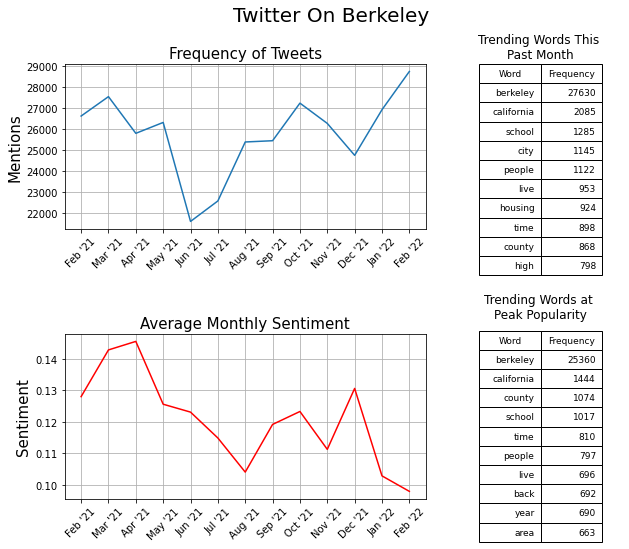

In [491]:

sentiment=collegeDF['comp'].to_list()
monthNames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plotTitle=''
# capitalizing all the words
for i,word in enumerate(keyword.split()):
    if(i!=len(keyword.split())):
        plotTitle += word.capitalize() + ' '
keyword = plotTitle
blah = collegeDF['count'].tolist()
highestPopPoint = blah.index(max(blah))

# start at the last completed month and count forward
months = []
for i in range(13):
    monthy = currentMonth-1
    monthy +=i
    if(monthy>12):
        monthy = monthy-12
        year = currentYear
    else:
        year = currentYear-1
    year = str(year)[2:]
    months.append(f'{monthNames[monthy-1]} \'{year}')

# fig = plt.figure(figsize=(15, 6))
# figure, axis = plt.subplots(2, 2)
# axis = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# ax3 = fig.add_subplot(123)
fig = plt.figure()

ax = plt.subplot2grid((5, 3), (0, 0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid((5, 3), (3, 0), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((6, 3), (1, 2), colspan=1)
ax4 = plt.subplot2grid((10, 3), (8, 2), colspan=1)



fig.set_size_inches(10, 8)
# Making all of the month labels line up to the data


ax.xaxis.set_major_locator(plt.MaxNLocator(14))
ax2.xaxis.set_major_locator(plt.MaxNLocator(14))
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
# ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
# print(sentiment)
popularity = collegeDF['count'].to_list()

ax.plot(months,popularity)
ax2.plot(months,sentiment,color='red')

tableDF = pd.DataFrame(collegeDF['Top Words'][13].items(),columns=['Word','Frequency'])
table2DF = pd.DataFrame(collegeDF['Top Words'][highestPopPoint].items(),columns=['Word','Frequency'])
table = ax3.table(cellText=tableDF.values, colLabels=tableDF.columns, loc='center')
table2 = ax4.table(cellText=table2DF.values, colLabels=table2DF.columns, loc='center')

ax.set_title('Frequency of Tweets',fontsize = 15)
ax3.set_title('Trending Words This \nPast Month',pad= 80)
ax4.set_title('Trending Words at \nPeak Popularity',pad= 100)
ax2.set_title('Average Monthly Sentiment',fontsize = 15)

ax.set_ylabel('Mentions',fontsize = 15)
ax2.set_ylabel('Sentiment',fontsize = 15)
ax.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)

ax2.grid(True)
ax.grid(True)


collegeDF['Top Words'][13]
fig.suptitle(f'Twitter On {keyword}',fontsize = 20)
# plt.xticks(rotation=45)
ax3.axis('off')
ax3.axis('tight')

# print(collegeDF['Top Words'][13])
#create data
# df = pd.DataFrame(np.random.randn(20, 2), columns=['First', 'Second'])

#create table

ax4.axis('off')
ax4.axis('tight')
#display table
table.set_fontsize(20)
table.scale(.75,1.6)
table2.set_fontsize(20)
table2.scale(.75,1.6)

file_path = os.path.join(file_dir, json_folder,'Graphics', (f'{keyword}.png'))

plt.savefig(file_path,dpi=300,facecolor='white', transparent=False)

In [492]:
blah = collegeDF['count'].tolist()
blah.index(max(blah))
print(blah)

[26622, 27547, 25798, 26317, 21600, 22576, 25386, 25446, 27237, 26271, 24750, 26924, 28746]
